In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from mpmath import besseljzero
from scipy.special import gamma
from scipy.special import jv, iv, ive
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_HSDM_2D(a, mu, ndt, mu_z, sigma_z, corr='noise', sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    
    while np.linalg.norm(x, 2) < a(rt):
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
    
    theta = np.arctan2(x[1], x[0]) 
    
    if corr == 'noise':
        return ndt+rt, theta, np.random.normal(mu_z, sigma_z)
    else:
        return ndt+rt, theta, np.random.normal(ndt, sigma_z)

In [3]:
def k(a, da, t, q, sigma=2):
    return 0.5 * (q - 0.5*sigma - da(t))

def psi(a, da, t, z, tau, q, sigma=2):
    kk = k(a, da, t, q, sigma)
    
    if 2*np.sqrt(a(t)*z)/(sigma*(t-tau))<=700:
        term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = iv(q/sigma-1, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    else:
        term1 = 1./(sigma*(t - tau))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = ive(q/sigma-1, (a(t) + z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * ive(q/sigma, (a(t) + z)/(sigma*(t-tau)))
    
    return term1 * term2 * (term3 * term4 + term5)

def ie_bessel_fpt(a, da, q, z, sigma=2, dt=0.1, T_max=2):
    g = [0]
    T = [0]
    g.append(-2*psi(a, da, dt, z, 0, q, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        s = -2 * psi(a, da, n*dt, z, 0, q, sigma)

        for j in range(1, n):
            if a(j*dt) == 0:
                continue
            
            s += 2 * dt * g[j] * psi(a, da, n*dt, a(j*dt), j*dt, q, sigma)

        g.append(s)
        T.append(n*dt)
        
    g = np.asarray(g)
    T = np.asarray(T)
    
    gt = interp1d(T, g)
    return gt

In [4]:
def HSDM_2D_joint_likelihood(prms, RT, Theta, Z):
    a = lambda t: prms[0] * np.exp(-prms[1]*t)
    a2 = lambda t: (a(t))**2
    da2 = lambda t: -2 * prms[1]*prms[0]*np.exp(-prms[1]*t) * a(t)
    
    ndt = prms[2]
    mu = np.array([prms[3], prms[4]])
    sig = prms[5]
        
    T_max = max(RT)
    fpt = ie_bessel_fpt(a2, da2, mu.shape[0], 0.000001, 
                        dt=0.05, T_max=T_max)
        
    log_lik = 0
    for i in range(len(RT)):
        rt, theta = RT[i], Theta[i]
        if rt - ndt > 0.0001 and rt - ndt < T_max:
            mu_dot_x0 = mu[0]*np.cos(theta)
            mu_dot_x1 = mu[1]*np.sin(theta)
            term1 = a(rt - ndt) * (mu_dot_x0 + mu_dot_x1)
            term2 = 0.5 * np.linalg.norm(mu, 2)**2 * (rt - ndt)

            density = np.exp(term1 - term2) * fpt(rt - ndt)
            
            if 0.1**14 < density:
                log_lik += -np.log(density) + 0.5*(Z[i] - ndt)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
            else:
                log_lik += -np.log(0.1**14) + 0.5*(Z[i] - ndt)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
        else:
            log_lik += -np.log(0.1**14)
        
    return log_lik

def HSDM_2D_behav_likelihood(prms, RT, Theta):
    a = lambda t: prms[0] * np.exp(-prms[1]*t)
    a2 = lambda t: (a(t))**2
    da2 = lambda t: -2 * prms[1]*prms[0]*np.exp(-prms[1]*t) * a(t)
    
    ndt = prms[2]
    mu = np.array([prms[3], prms[4]])
        
    T_max = max(RT)
    fpt = ie_bessel_fpt(a2, da2, mu.shape[0], 0.000001, 
                        dt=0.05, T_max=T_max)
        
    log_lik = 0
    for i in range(len(RT)):
        rt, theta = RT[i], Theta[i]
        if rt - ndt > 0.0001 and rt - ndt < T_max:
            mu_dot_x0 = mu[0]*np.cos(theta)
            mu_dot_x1 = mu[1]*np.sin(theta)
            term1 = a(rt - ndt) * (mu_dot_x0 + mu_dot_x1)
            term2 = 0.5 * np.linalg.norm(mu, 2)**2 * (rt - ndt)

            density = np.exp(term1 - term2) * fpt(rt - ndt)
            
            if 0.1**14 < density:
                log_lik += -np.log(density) 
            else:
                log_lik += -np.log(0.1**14)
        else:
            log_lik += -np.log(0.1**14)
        
    return log_lik

In [5]:
recovery_dic = {'b0_true': [],
                'b0_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'ndt_true': [],
                'ndt_estimate': [],
                'mu1_true': [],
                'mu1_estimate': [],
                'mu2_true': [],
                'mu2_estimate': [],
                'sigma_true':[],
                'sigma_estimate':[],
                'mu_z':[],
                'std_z': [],
                'index':[],
                'corr':[]}

min_b0 = 2
max_b0 = 5

min_lambda = .1
max_lambda = 2

min_ndt = 0.1
max_ndt = 1

min_mu = -3
max_mu = 3

In [73]:
for n in tqdm(range(40)):
    b0 = np.random.uniform(min_b0, max_b0)
    lamb = np.random.uniform(min_lambda, max_lambda)
    a = lambda t: b0 * np.exp(-lamb*t)
    
    ndt = np.random.uniform(min_ndt, max_ndt)
    mu = np.array([np.random.uniform(min_mu, max_mu), 
                   np.random.uniform(min_mu, max_mu)])
    
    mu_z = np.random.uniform(0.05, 3)
    while np.abs(mu_z - ndt)<.5:
        mu_z = np.random.uniform(0.05, 3)
        
    sigma_z = np.random.uniform(0.05, 1)
    
    RT = []
    Theta = []
    Z = []
    
    if np.random.random()<0.5:
        corr = 'noise'
        for i in range(500):
            rt, theta, z = simulate_HSDM_2D(a, mu, ndt, mu_z, sigma_z, corr=corr)
            RT.append(rt)
            Theta.append(theta)
            Z.append(z)
    else:
        corr = 'ndt'
        for i in range(500):
            rt, theta, z = simulate_HSDM_2D(a, mu, ndt, mu_z, sigma_z, corr=corr)
            RT.append(rt)
            Theta.append(theta)
            Z.append(z)
    
    min_ans_j = differential_evolution(HSDM_2D_joint_likelihood,
                                       args=(RT, Theta, Z),
                                       bounds=[(min_b0, max_b0), (min_lambda, max_lambda), 
                                               (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu),
                                               (0.05, 5)])
    
    min_ans_j = minimize(HSDM_2D_joint_likelihood,
                         args=(RT, Theta, Z),
                         method='nelder-mead',
                         x0=min_ans_j.x,
                         bounds=[(min_b0, max_b0), (min_lambda, max_lambda),
                                 (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu),
                                 (0.05, 5)])
    
    min_ans_b = differential_evolution(HSDM_2D_behav_likelihood,
                                       args=(RT, Theta),
                                       bounds=[(min_b0, max_b0), (min_lambda, max_lambda), 
                                               (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu)])
    
    min_ans_b = minimize(HSDM_2D_behav_likelihood,
                        args=(RT, Theta),
                        method='nelder-mead',
                        x0=min_ans_b.x,
                        bounds=[(min_b0, max_b0), (min_lambda, max_lambda),
                               (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu)])
    
    recovery_dic['b0_true'].append(b0)
    recovery_dic['lambda_true'].append(lamb)
    recovery_dic['ndt_true'].append(ndt)
    recovery_dic['mu1_true'].append(mu[0])
    recovery_dic['mu2_true'].append(mu[1])
    recovery_dic['sigma_true'].append(sigma_z)
    recovery_dic['mu_z'].append(mu_z)
    recovery_dic['std_z'].append(np.std(Z))
    recovery_dic['corr'].append(corr)
    recovery_dic['index'].append(min_ans_j.x[5]/np.std(Z) * (1 + np.abs(min_ans_b.x[2] - min_ans_j.x[2])))

    recovery_dic['b0_estimate'].append(min_ans_j.x[0])
    recovery_dic['lambda_estimate'].append(min_ans_j.x[1])
    recovery_dic['ndt_estimate'].append(min_ans_j.x[2])
    recovery_dic['mu1_estimate'].append(min_ans_j.x[3])
    recovery_dic['mu2_estimate'].append(min_ans_j.x[4])
    recovery_dic['sigma_estimate'].append(min_ans_j.x[5])

100%|████████████████████████████████████| 40/40 [1:18:02<00:00, 117.06s/it]


In [74]:
recovery_df = pd.DataFrame(recovery_dic)
recovery_df['sig_to_var'] = recovery_df['sigma_estimate']/recovery_df['std_z']
recovery_df

,b0_true,b0_estimate,lambda_true,lambda_estimate,ndt_true,ndt_estimate,mu1_true,mu1_estimate,mu2_true,mu2_estimate,sigma_true,sigma_estimate,mu_z,std_z,index,corr,sig_to_var
0,3.615634,3.617627,1.555904,1.589701,0.282179,0.295179,0.430115,0.502035,0.545804,0.552048,0.641097,0.640775,2.475487,0.640777,1.009997,ndt,0.999996
1,2.566888,2.338756,0.468001,0.363179,0.977166,1.000000,-0.896254,-0.917334,-1.445204,-1.474933,0.184693,0.571002,1.540213,0.181105,3.580833,noise,3.152883
2,4.638438,2.000000,0.502942,0.100000,0.354495,0.777553,-2.370132,-2.880821,1.738344,2.006267,0.232614,0.782525,1.524277,0.228233,4.780570,noise,3.428630
3,2.195735,2.000000,0.835300,0.823904,0.454115,0.512325,2.135629,2.146274,0.158734,0.124121,0.362783,1.254630,1.721004,0.354847,3.826996,noise,3.535696
4,2.435510,2.392510,0.273834,0.265269,0.998907,1.000000,1.072296,1.005860,1.887588,1.860580,0.998132,0.982364,2.122758,0.980124,1.099858,ndt,1.002286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,4.243585,4.903385,0.793572,0.931019,0.815093,0.794830,-1.793457,-1.723405,1.323812,1.369169,0.387798,0.365028,2.848207,0.364943,1.147450,ndt,1.000234
196,2.898821,2.000000,0.681980,0.279557,0.388351,0.542798,-2.134454,-2.459342,2.219093,2.598609,0.321520,2.020164,2.517570,0.317888,8.056198,noise,6.354965
197,3.284797,3.534616,0.806252,0.944217,0.960889,0.959245,-1.960477,-1.879881,-0.200898,-0.227203,0.680411,0.680636,2.621912,0.680524,1.051029,ndt,1.000165
198,2.801401,2.033173,1.784402,1.602454,0.411489,0.494008,-1.977074,-2.167078,-2.653984,-2.898525,0.224258,2.224205,2.717940,0.217651,11.270002,noise,10.219141


Text(0, 0.5, '$\\sigma_{z}/Var(Z)$')

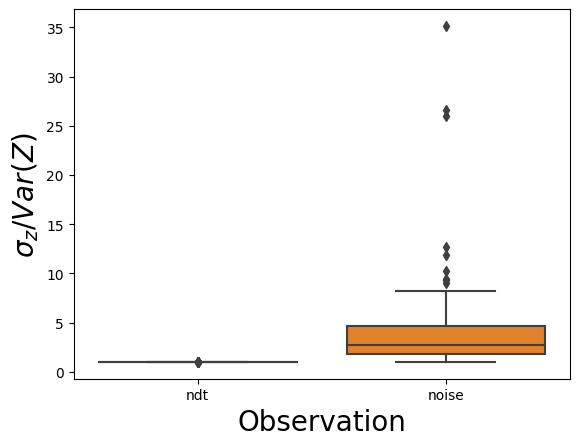

In [83]:
# plt.figure(figsize=(8, 4))
# plt.subplot(121)
# sns.boxplot(x='corr', y='index', data=recovery_df);

# plt.subplot(122)
sns.boxplot(x='corr', y='sig_to_var', data=recovery_df);
plt.xlabel('Observation', fontsize=20)
plt.ylabel(r'$\sigma_{z}/Var(Z)$', fontsize=20)

In [76]:
recovery_df.groupby(by='corr')['sig_to_var'].min()['noise']

1.0270872958472648

In [77]:
recovery_df.groupby(by='corr')['sig_to_var'].max()['ndt']

1.0039324398242964

In [78]:
recovery_df.groupby(by='corr')['index'].min()['noise']

1.1590912842794245

In [79]:
recovery_df.groupby(by='corr')['index'].max()['ndt']

1.1983557359292811

In [84]:
recovery_df.to_csv('Exponential_rec.csv')